In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff

# Define the ODE systems
def fast_system(y, t, eps):
    phi, u, c1, c2, j1, j2, w = y
    dphidt = u 
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u - eps * j1
    dc2dt  = -z2 * c2 * u - eps * j2
    dj1dt  = 0
    dj2dt  = 0
    dwdt   = eps
    
    return [dphidt, dudt, dc1dt, dc2dt, dj1dt, dj2dt, dwdt]


def subfast_system(y, t, eps):
    phi, u, c1, c2, j1, j2, w = y
    dphidt = u 
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u 
    dc2dt  = -z2 * c2 * u 
    dj1dt  = 0
    dj2dt  = 0
    dwdt   = 0
    
    return [dphidt, dudt, dc1dt, dc2dt, dj1dt, dj2dt, dwdt]



t_end = 20
t   =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0,-t_end, 100)
eps = 0.01
T_slow_end = 1
tau = np.linspace(0, T_slow_end, 100)

t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 7

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
      
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [2]:
z1, z2 = 1.0 , -1.0
V  = -10
l  = 0.5
l2 = 0.1
l1 = l + 0.1

r  = 0.7
r1 = r 
r2 = 0.01


In [3]:
# Initial points:
phi_init, c1_init, c2_init,  w_init = V, l1 , l2, 0.0  
print('The initial points of the BVP:', f"phi_init = {phi_init}, c1_init  = {c1_init}, c2_init = {c2_init}, w_init   = {w_init} ")

#phi_slow_init, phi_slow_end = V, 0.0
#c1_slow_init, c1_slow_end   = l, r 
#c2_slow_init, c2_slow_end  = l, r
w_slow_init, w_slow_end  = 0.0, 1.0
u_a, u_b =  0.0, 0.0

phi_end, c1_end, c2_end, w_end = 0.0, r1, r2 , 1.0
print('The ending points of the BVP:', f"phi_end = {phi_end}, c1_end  = {c1_end}, c2_end = {c2_end}, w_end   = {w_end} ")
 
#J1 = np.random.uniform(2 * min(0, V), 2 * max(0, V))/ abs(V)
# J1 is obtained as above because the sign of J_k is the same as z_kV+ ln(l_k/r_k)

#J2 = np.random.uniform(-max(0, V) * 2, -min(0, V) * 2)/ abs(V)


The initial points of the BVP: phi_init = -10, c1_init  = 0.6, c2_init = 0.1, w_init   = 0.0 
The ending points of the BVP: phi_end = 0.0, c1_end  = 0.7, c2_end = 0.01, w_end   = 1.0 


In [4]:
phys_weight  = 1
init_weight  = 1
bndry_weight = 1
def loss_func_fast(model, t_tensor, phi_init, c1_init, c2_init, w_init,\
                                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                                    eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    phi_pred_fast, u_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    c1_pred_fast, c2_pred_fast = pred_fast[:, 2].unsqueeze(1), pred_fast[:, 3].unsqueeze(1)
    j1_pred_fast, j2_pred_fast = pred_fast[:, 4].unsqueeze(1), pred_fast[:, 5].unsqueeze(1)
    w_pred_fast = pred_fast[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt = torch.autograd.grad(phi_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    du_dt = torch.autograd.grad(u_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt = torch.autograd.grad(c1_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt = torch.autograd.grad(c2_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt = torch.autograd.grad(j1_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt = torch.autograd.grad(j2_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt = torch.autograd.grad(w_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast =  dphi_dt - u_pred_fast
    residual2_fast =  du_dt + z1 * c1_pred_fast + z2 * c2_pred_fast
    residual3_fast =  dc1_dt + z1 * c1_pred_fast * u_pred_fast #+ eps * j1_pred_fast
    residual4_fast =  dc2_dt + z2 * c2_pred_fast * u_pred_fast #+ eps * j2_pred_fast
    residual5_fast =  dj1_dt  
    residual6_fast =  dj2_dt 
    residual7_fast =  dw_dt #- eps

    #first integrals
    #residual8_fast = torch.log(c1_pred_fast) + z1 * phi_pred_fast - torch.log(c1_init) - z1 * phi_init
    #residual9_fast = torch.log(c2_pred_fast) + z2 * phi_pred_fast - torch.log(c2_init) - z2 * phi_init
    #residual10_fast = 0.5 * u_pred_fast ** 2 - c1_pred_fast - c2_pred_fast-(0.5 * u_a ** 2 - c1_pred_fast[-1] - c2_pred_fast[-1])

    
    init_loss_fast = torch.square(phi_pred_fast[0] - phi_init) +\
                     torch.square(c1_pred_fast[0] - c1_init)  +\
                     torch.square(c2_pred_fast[0] - c2_init)  +\
                     torch.square(w_pred_fast[0] - w_init)  
    
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2 +\
                                   residual5_fast**2 + residual6_fast**2 +\
                                   residual7_fast**2 )
    boundary_loss_fast = torch.square(phi_pred_fast[-1] - phi_slow_init) +\
                         torch.square(u_pred_fast[-1] - u_a) +\
                         torch.square(c1_pred_fast[-1] - c1_slow_init) +\
                         torch.square(c2_pred_fast[-1] - c2_slow_init) +\
                         torch.square(z1*c1_pred_fast[-1] + z2*c2_pred_fast[-1]) +\
                         torch.square(w_pred_fast[-1] - w_slow_init) 

        
    total_loss_fast   = phys_weight * physics_loss_fast +\
                        init_weight * init_loss_fast + bndry_weight * boundary_loss_fast
    return total_loss_fast

def loss_func_slow(model, tau_tensor, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    phi_pred_slow, u_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)
    c1_pred_slow, c2_pred_slow = pred_slow[:, 2].unsqueeze(1), pred_slow[:, 3].unsqueeze(1)
    j1_pred_slow, j2_pred_slow = pred_slow[:, 4].unsqueeze(1), pred_slow[:, 5].unsqueeze(1)
    w_pred_slow = pred_slow[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau = torch.autograd.grad(phi_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau = torch.autograd.grad(u_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau = torch.autograd.grad(c1_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau = torch.autograd.grad(c2_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau = torch.autograd.grad(j1_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau = torch.autograd.grad(j2_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau = torch.autograd.grad(w_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p = - (z1 * j1_pred_slow + z2 * j2_pred_slow)/(z1 * (z1 - z2) * c1_pred_slow)
    #p2 = (z1 * j1_pred_slow + z2 * j2_pred_slow) #/(z1 * (z1 - z2) * c1_pred_slow)
        
    residual1_slow = u_pred_slow #- eps * p
    residual2_slow = dphi_dtau - p
    residual3_slow = dc1_dtau + z1 * c1_pred_slow * p + j1_pred_slow #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow = dc2_dtau + z2 * c2_pred_slow * p + j2_pred_slow #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow = dj1_dtau
    residual6_slow = dj2_dtau 
    residual7_slow = dw_dtau - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow = z1 * c1_pred_slow + z2 * c2_pred_slow
    
    #residual1_slow = dphi_dtau - u_pred_slow
    #residual2_slow = du_dtau 
    #residual3_slow = dc1_dtau  + z1 * c1_pred_slow * u_pred_slow 
    #residual4_slow = dc2_dtau  + z2 * c2_pred_slow * u_pred_slow 
       
    
    init_loss_slow = torch.square(phi_pred_slow[0] - phi_slow_init) +\
                     torch.square(u_pred_slow[0] - u_a) +\
                     torch.square(c1_pred_slow[0] - c1_slow_init)  +\
                     torch.square(c2_pred_slow[0] - c2_slow_init)  +\
                     torch.square(w_pred_slow[0] - w_slow_init)  
    
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 +\
                                   residual3_slow**2 + residual4_slow**2 +\
                                   residual5_slow**2 + residual6_slow**2 +\
                                   residual7_slow**2 + residual8_slow**2)
    boundary_loss_slow =   torch.square(phi_pred_slow[-1] - phi_slow_end) +\
                           torch.square(u_pred_slow[-1] - u_b) +\
                           torch.square(c1_pred_slow[-1] - c1_slow_end)  +\
                           torch.square(c2_pred_slow[-1] - c2_slow_end)  +\
                           torch.square(j1_pred_slow[-1] - j1_pred_slow[0])+\
                           torch.square(j2_pred_slow[-1] - j2_pred_slow[0])+\
                           torch.square(w_pred_slow[-1] - w_slow_end) 
    
    #u_b = u_pred_slow[-1]
    
    total_loss_fast   = phys_weight * physics_loss_slow +\
                        init_weight * init_loss_slow + bndry_weight * boundary_loss_slow
    return total_loss_fast


def loss_func_fast2(model, t2_tensor, phi_end, c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    phi_pred_fast2, u_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    c1_pred_fast2, c2_pred_fast2 = pred_fast2[:, 2].unsqueeze(1), pred_fast2[:, 3].unsqueeze(1)
    j1_pred_fast2, j2_pred_fast2 = pred_fast2[:, 4].unsqueeze(1), pred_fast2[:, 5].unsqueeze(1)
    w_pred_fast2 = pred_fast2[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt2 = torch.autograd.grad(phi_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    du_dt2 = torch.autograd.grad(u_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt2 = torch.autograd.grad(c1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt2 = torch.autograd.grad(c2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt2 = torch.autograd.grad(j1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt2 = torch.autograd.grad(j2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt2 = torch.autograd.grad(w_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast2 =  dphi_dt2 - u_pred_fast2
    residual2_fast2 =  du_dt2 + z1 * c1_pred_fast2 + z2 * c2_pred_fast2
    residual3_fast2 =  dc1_dt2 + z1 * c1_pred_fast2 * u_pred_fast2 #+ eps * j1_pred_fast2
    residual4_fast2 =  dc2_dt2 + z2 * c2_pred_fast2 * u_pred_fast2 #+ eps * j2_pred_fast2
    residual5_fast2 =  dj1_dt2  
    residual6_fast2 =  dj2_dt2 
    residual7_fast2 =  dw_dt2 #- eps

    #first integrals
    #residual8_fast2 = torch.log(c1_pred_fast2) + z1 * phi_pred_fast2 - torch.log(c1_end) - z1 * phi_end
    #residual9_fast2 = torch.log(c2_pred_fast2) + z2 * phi_pred_fast2 - torch.log(c2_end) - z2 * phi_end
    #residual10_fast2 = 0.5 * u_pred_fast2 ** 2 - c1_pred_fast2 - c2_pred_fast2 - (0.5 * u_b ** 2 - c1_pred_fast2[-1] - c2_pred_fast2[-1])

    
    init_loss_fast2 = torch.square(phi_pred_fast2[0] - phi_end) +\
                      torch.square(c1_pred_fast2[0] - c1_end)  +\
                      torch.square(c2_pred_fast2[0] - c2_end)  +\
                      torch.square(w_pred_fast2[0] - w_end)  
    
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                   residual3_fast2**2 + residual4_fast2**2 +\
                                   residual5_fast2**2 + residual6_fast2**2 +\
                                   residual7_fast2**2 )
    boundary_loss_fast2 = torch.square(phi_pred_fast2[-1] - phi_slow_end) +\
                          torch.square(u_pred_fast2[-1] - u_b) +\
                          torch.square(c1_pred_fast2[-1] - c1_slow_end) +\
                          torch.square(c2_pred_fast2[-1] - c2_slow_end) +\
                          torch.square(z1*c1_pred_fast2[-1] + z2*c2_pred_fast2[-1]) +\
                          torch.square(w_pred_fast2[-1] - w_slow_end) 
    
    total_loss_fast2   = phys_weight * physics_loss_fast2 +\
                         init_weight * init_loss_fast2 + bndry_weight * boundary_loss_fast2
    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2, t_tensor, tau_tensor, t2_tensor,\
                    phi_init, c1_init, c2_init, w_init,\
                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                    phi_end, c1_end, c2_end, w_end,\
                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                    eps, weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, phi_init, c1_init, c2_init, w_init,\
                               phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, phi_end, c1_end, c2_end, w_end,\
                                phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end, eps)

    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss

Epoch 0, Total Loss: 311.45109291945784
Epoch 1000, Total Loss: 4.3770791404381075
Epoch 2000, Total Loss: 0.06666748639114382
Epoch 3000, Total Loss: 0.028439509848050836
Epoch 4000, Total Loss: 0.021543349650279365
Epoch 5000, Total Loss: 0.018770631132046006
Epoch 6000, Total Loss: 0.016782146922580874
Epoch 7000, Total Loss: 0.014400991027336467
Epoch 8000, Total Loss: 0.011037088376690974
Epoch 9000, Total Loss: 0.007695665402773563
Epoch 10000, Total Loss: 0.005296950342659127
Epoch 11000, Total Loss: 0.004351198293118976
Epoch 12000, Total Loss: 0.0039792066137451215
Epoch 13000, Total Loss: 0.0038026924930202126
Epoch 14000, Total Loss: 0.003727920757436657
Epoch 15000, Total Loss: 0.003652400645406161
Epoch 16000, Total Loss: 0.0036738762120554196
Epoch 17000, Total Loss: 0.003606091330946779
Epoch 18000, Total Loss: 0.0035916138147903285
Epoch 19000, Total Loss: 0.0035836620163806577


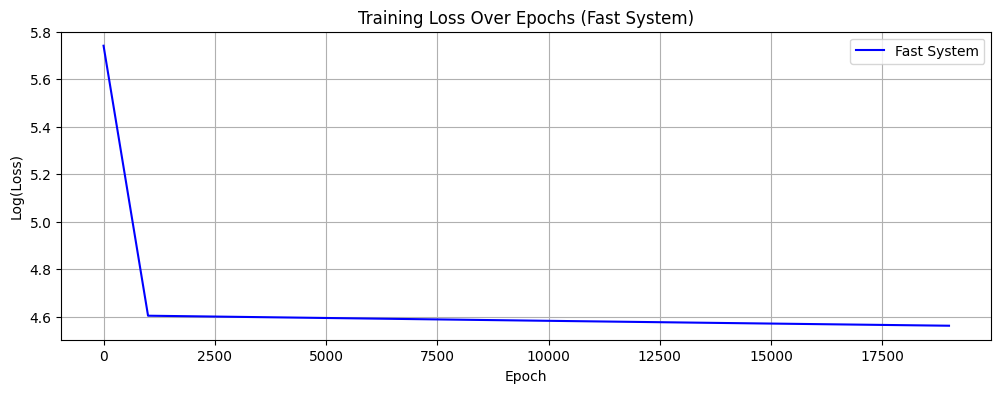

In [5]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)  
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) +\
                                 list(model_slow.parameters()) +\
                                 list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 20000

    phi_slow_init, phi_slow_end =  np.random.uniform(V-1, V+1) , np.random.uniform(-0.5, 0.5) #-1, 2 #
    c1_slow_init, c1_slow_end  = np.random.uniform(0, 1) , np.random.uniform(0, 1)
    c2_slow_init, c2_slow_end  = np.random.uniform(0, 1) , np.random.uniform(0, 1)

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                    t_tensor, tau_tensor, t2_tensor,\
                                    phi_init, c1_init, c2_init, w_init,\
                                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                                    phi_end, c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            phi_pred_fast, u_pred_fast, c1_pred_fast, c2_pred_fast, j1_pred_fast, j2_pred_fast, w_pred_fast = model_fast(t_tensor).numpy().T
            phi_pred_slow, u_pred_slow, c1_pred_slow, c2_pred_slow, j1_pred_slow, j2_pred_slow, w_pred_slow = model_slow(tau_tensor).numpy().T
            phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
            #J1, J2   = j1_pred_slow[0], j2_pred_slow[0]
            #u_a, u_b = u_pred_fast[-1], u_pred_fast2[-1]
            phi_slow_init = phi_pred_slow[0]
            phi_slow_end = phi_pred_slow[-1]
            c1_slow_init, c1_slow_end = c1_pred_slow[0], c1_pred_slow[-1]
            c2_slow_init, c2_slow_end = c2_pred_slow[0], c2_pred_slow[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}') 
        loss_values.append(loss_total.item())
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_slow.eval()
    model_fast2.eval()
    with torch.no_grad():
        # Predictions for fast system
        phi_pred_fast, u_pred_fast, c1_pred_fast, c2_pred_fast, j1_pred_fast, j2_pred_fast, w_pred_fast = model_fast(t_tensor).numpy().T
        phi_pred_slow, u_pred_slow, c1_pred_slow, c2_pred_slow, j1_pred_slow, j2_pred_slow, w_pred_slow = model_slow(tau_tensor).numpy().T
        phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
        phi_slow_init = phi_pred_slow[0]
        phi_slow_end = phi_pred_slow[-1]
        c1_slow_init, c1_slow_end = c1_pred_slow[0], c1_pred_slow[-1]
        c2_slow_init, c2_slow_end = c2_pred_slow[0], c2_pred_slow[-1]
    

In [6]:
#print(J1)
#print(J2)
print(j1_pred_fast.shape)
print(j1_pred_fast[0])
print(j1_pred_fast[-1])
print('')

print(j1_pred_slow[0])
print(j1_pred_slow[-1])
print('')

print(j1_pred_fast2[0])
print(j1_pred_fast2[-1])
print('')

(100,)
-0.24158044432997583
-0.24158019632591077

-0.07331530687375583
-0.07334001508477457

0.10113400360244378
0.10119245433564295



In [7]:
print(j2_pred_fast.shape)
print(j2_pred_fast[0])
print(j2_pred_fast[-1])
print('')

print(j2_pred_slow[0])
print(j2_pred_slow[-1])
print('')

print(j2_pred_fast2[0])
print(j2_pred_fast2[-1])
print('')

(100,)
0.07044449357052746
0.07044481312748961

-0.024821407212332065
-0.02477410748434137

0.11925364039734515
0.11924875499623988



In [8]:
print(u_pred_fast.shape)
print(u_pred_fast[0])
print(u_pred_fast[-1])
print('')

print(u_pred_slow[0])
print(u_pred_slow[-1])
print('')

print(u_pred_fast2[0])
print(u_pred_fast2[-1])
print('')

u_length = len(u_pred_slow)
print('u_length=',u_length)
zero_vector = np.zeros(u_length)

(100,)
1.232547748094857
0.003448137072487867

-0.00019357727558465265
-0.00016695967425087513

-0.8421863952492423
0.0021287172648161157

u_length= 100


In [9]:
print(phi_pred_fast.shape)
print(phi_pred_fast[0])
print(phi_pred_fast[-1])
print('')


(100,)
-10.000453116654255
-0.11232991074981502



In [10]:
print(w_pred_fast.shape)
print(np.max(w_pred_fast))
print(w_pred_fast[-1])
print('')

print(w_pred_slow[0])
print(w_pred_slow[-1])
print('')

print(w_pred_fast2[0])
print(w_pred_fast2[-1])
print('')

(100,)
0.0009508490240460864
-9.11318097548651e-05

0.0003004153093526529
1.0002783987383164

1.0000209408299412
0.9998030698154399



/tmp/ipykernel_69/1894473492.py:23: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_69/1894473492.py:24: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_69/1894473492.py:25: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_69/1894473492.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


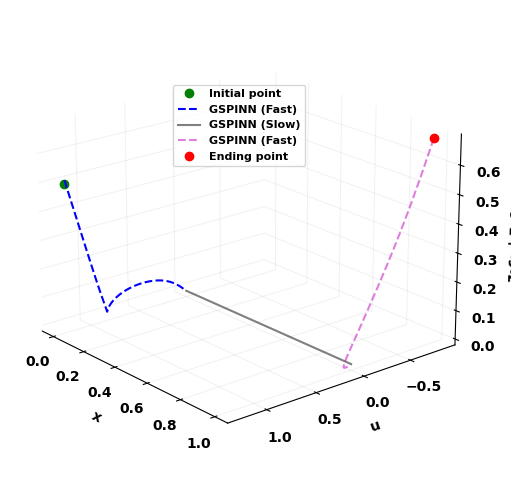

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')  # Set the background color of the 3D plot

# Your existing plots
ax.plot(w_init, u_pred_fast[0], z1 * c1_init + z2 * c2_init, 'go', label='Initial point')
ax.plot(w_pred_fast, u_pred_fast, z1 * c1_pred_fast + z2 * c2_pred_fast, 'b--', label='GSPINN (Fast)')
ax.plot(w_pred_slow + w_pred_fast[-1], u_pred_slow + u_a, z1 * c1_pred_slow + z2 * c2_pred_slow + z1 * c1_slow_init + z2 * c2_slow_init, 'k-', label='GSPINN (Slow)', alpha=0.5)
ax.plot(w_pred_fast2, u_pred_fast2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2, 'm--', label='GSPINN (Fast)', alpha=0.5)
ax.plot(w_end, u_pred_fast2[0], z1 * c1_end + z2 * c2_end, 'ro', label='Ending point')

ax.set_xlabel('$\\mathbf{x}$', fontweight='bold')
ax.set_ylabel('$\\mathbf{u}$', fontweight='bold')
ax.set_zlabel('$\\mathbf{z_1 c_1 + z_2 c_2}$', labelpad=2.3, fontweight='bold')
ax.legend(prop={'weight': 'bold', 'size': 8}, bbox_to_anchor=(0.65, 0.85))
ax.invert_xaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

# Update tick label properties
ax.tick_params(axis='x', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=2, length=5)
ax.tick_params(axis='z', labelsize=10, labelcolor='black', width=2, length=5)

# Apply bold font to tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    label.set_fontweight('bold')

# Rotating the figure by 20 degrees
ax.view_init(elev=20, azim=140)

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


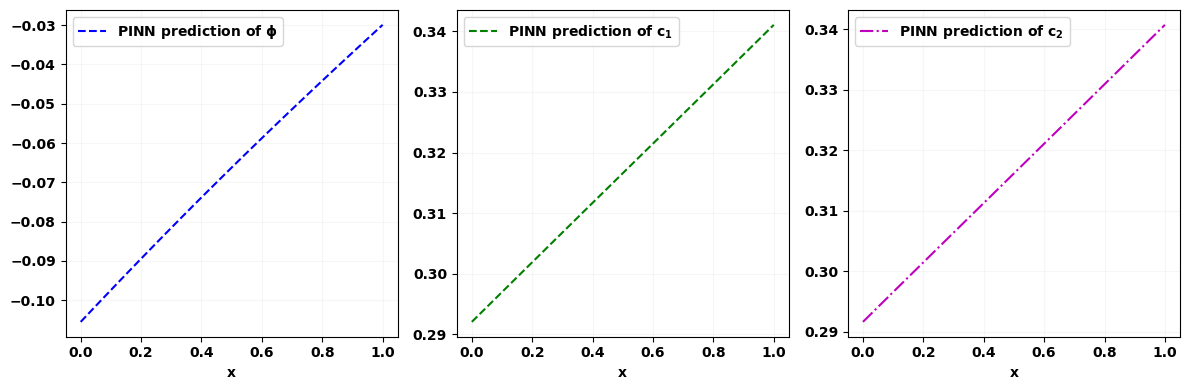

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(tau, phi_pred_slow, 'b--', label='PINN prediction of $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, c1_pred_slow, 'g--', label='PINN prediction of $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(tau, c2_pred_slow, 'm-.', label='PINN prediction of $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


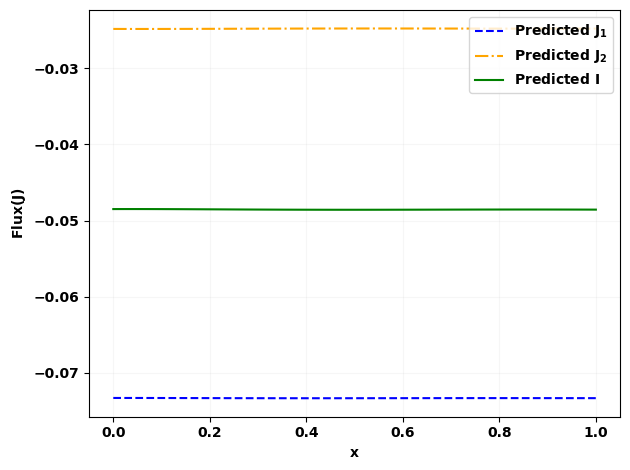

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.4, 4.8))

# Plot the data
plt.plot(tau, j1_pred_slow, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(tau, j2_pred_slow, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(tau, z1*j1_pred_slow + z2*j2_pred_slow, '-', color='green', label='Predicted $\\mathbf{I}$')

# Label the axes
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{Flux (J)}$', fontweight='bold')

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Add grid and legend
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


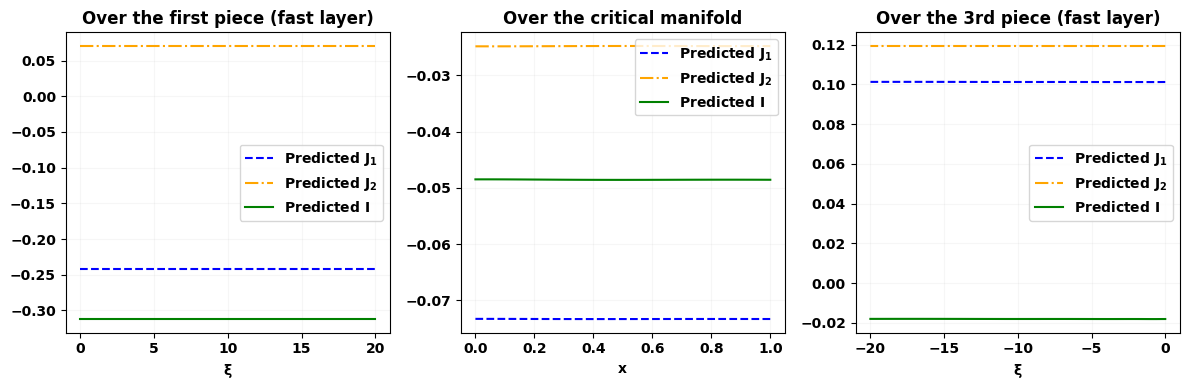

array([0.07044449, 0.0704445 ])

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j1_pred_fast, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(t, j2_pred_fast, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(t, z1*j1_pred_fast + z2*j2_pred_fast, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title('Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, j1_pred_slow, 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(tau, j2_pred_slow, '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(tau, z1*j1_pred_slow + z2*j2_pred_slow, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title('Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2 , 'b--', label='Predicted $\\mathbf{J_1}$')
plt.plot(t2, j2_pred_fast2 , '-.', color='orange', label='Predicted $\\mathbf{J_2}$')
plt.plot(t2, z1*j1_pred_fast2 + z2*j2_pred_fast2, '-', color='green', label='Predicted $\\mathbf{I}$')

plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title('Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()
j2_pred_fast[:2]

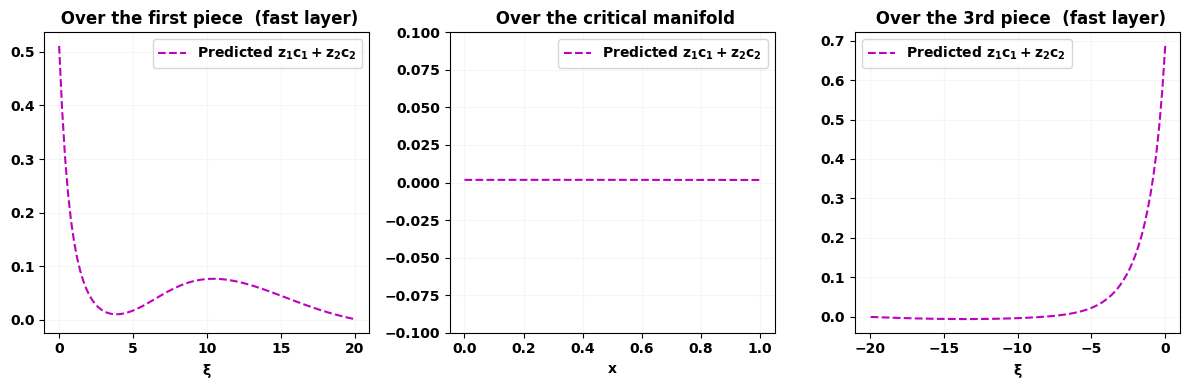

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, z1 * c1_pred_fast + z2 * c2_pred_fast, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece  (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

zc_slow_init = z1 * c1_pred_fast[-1] + z2 * c2_pred_fast[-1]
plt.subplot(1, 3, 2)
plt.plot(tau, z1 * c1_pred_slow + z2 * c2_pred_slow + zc_slow_init, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylim(-0.1, 0.1)
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2, 'm--', label='Predicted $\\mathbf{z_1 c_1+ z_2  c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece  (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


### In the following, we would like to investigate whether the variables are fast or slow based on their dynamic on fast layers and slow layer:

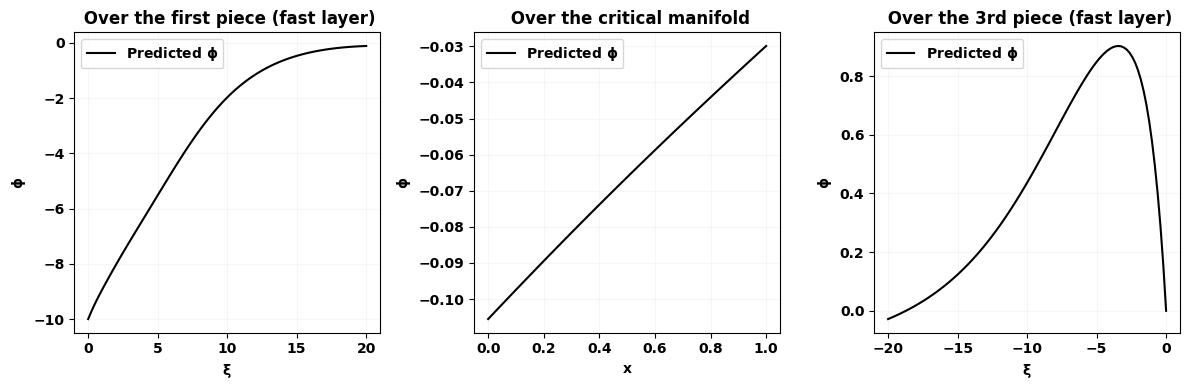

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, phi_pred_fast, 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, phi_pred_slow, 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, phi_pred_fast2 , 'k-', label='Predicted $\\mathbf{\\phi}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{\\phi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


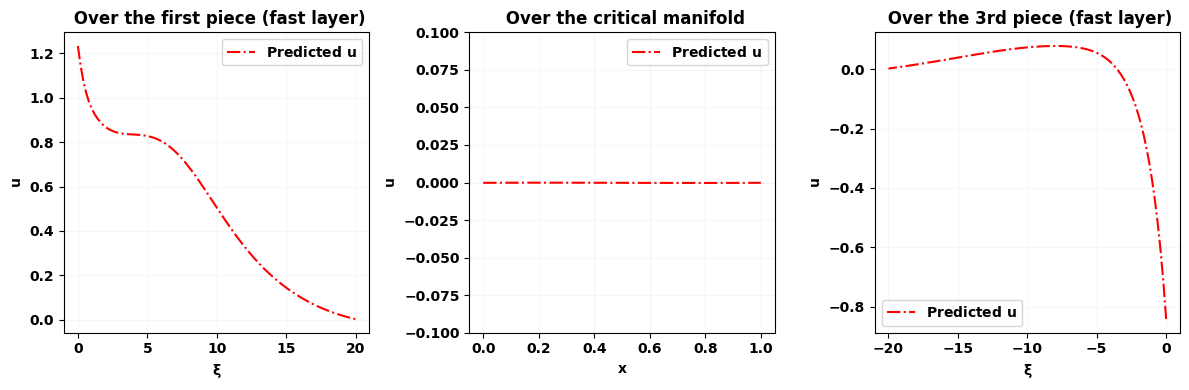

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, u_pred_fast, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, u_pred_slow, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.ylim(-0.1, 0.1)
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, u_pred_fast2, 'r-.', label='Predicted $\\mathbf{u}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{u}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


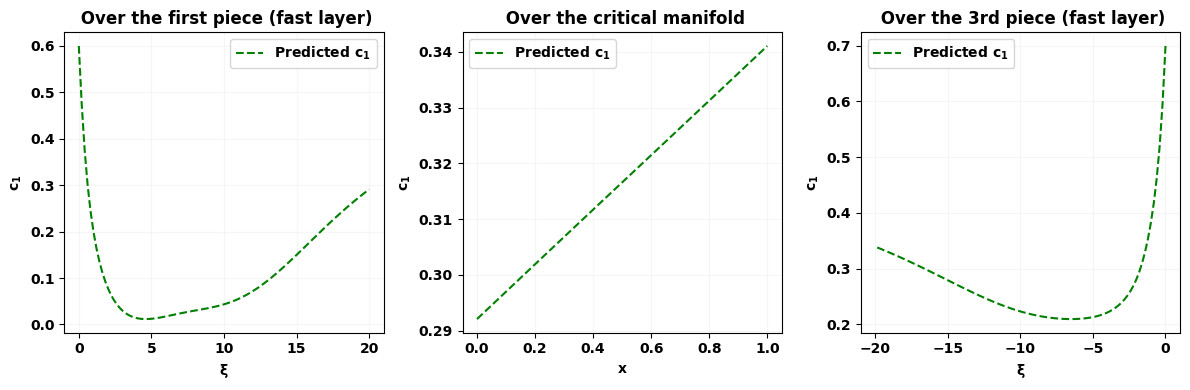

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, c1_pred_fast, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, c1_pred_slow, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, c1_pred_fast2, 'g--', label='Predicted $\\mathbf{c_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_1}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


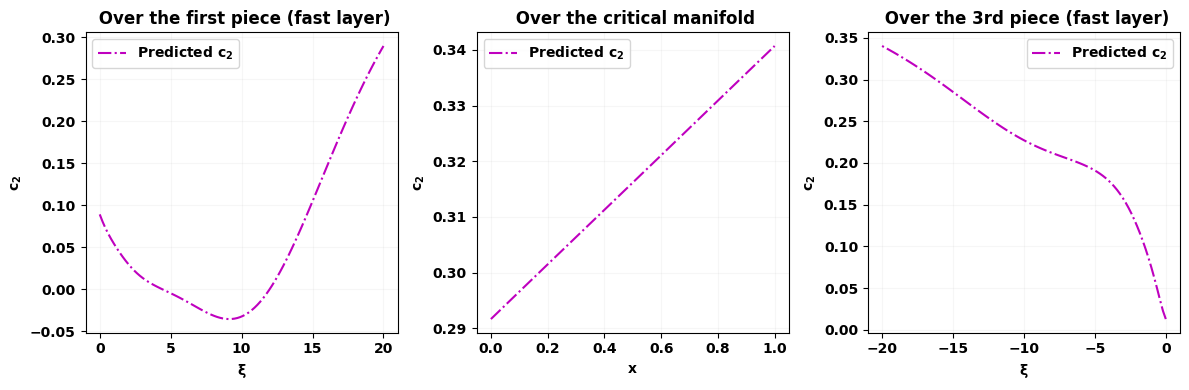

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, c2_pred_fast, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, c2_pred_slow, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, c2_pred_fast2, 'm-.', label='Predicted $\\mathbf{c_2}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.ylabel('$\\mathbf{c_2}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


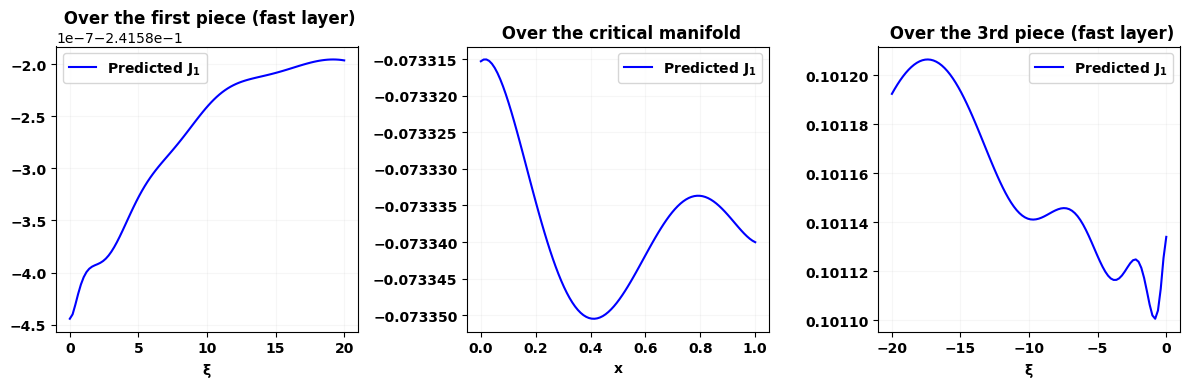

array([-0.24158044, -0.24158044, -0.24158043, -0.24158042, -0.24158041])

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j1_pred_fast, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, j1_pred_slow, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
#plt.ylim(-5.765, -5.72)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2, 'b-', label='Predicted $\\mathbf{J_1}$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

j1_pred_fast[:5]


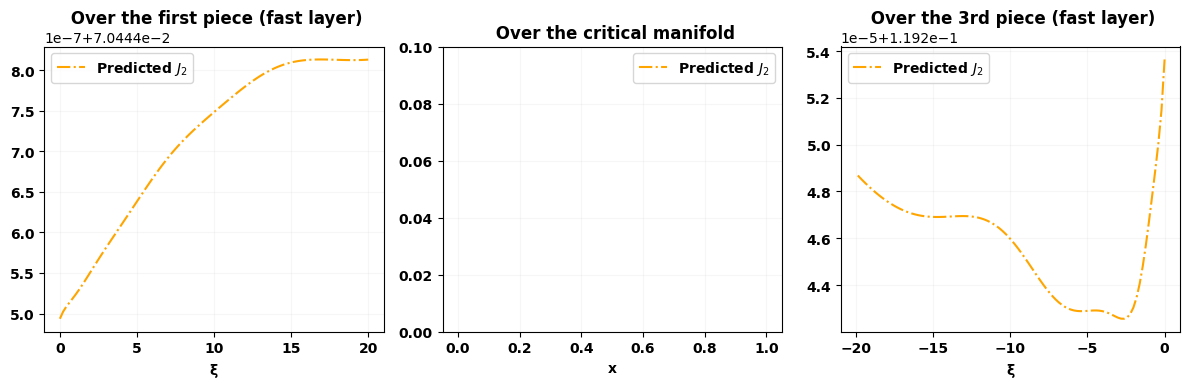

array([0.11925364, 0.11925146, 0.11925004, 0.11924889, 0.1192478 ])

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j2_pred_fast, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, j2_pred_slow, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
plt.ylim(0., 0.1)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j2_pred_fast2, '-.', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

j2_pred_fast2[:5]

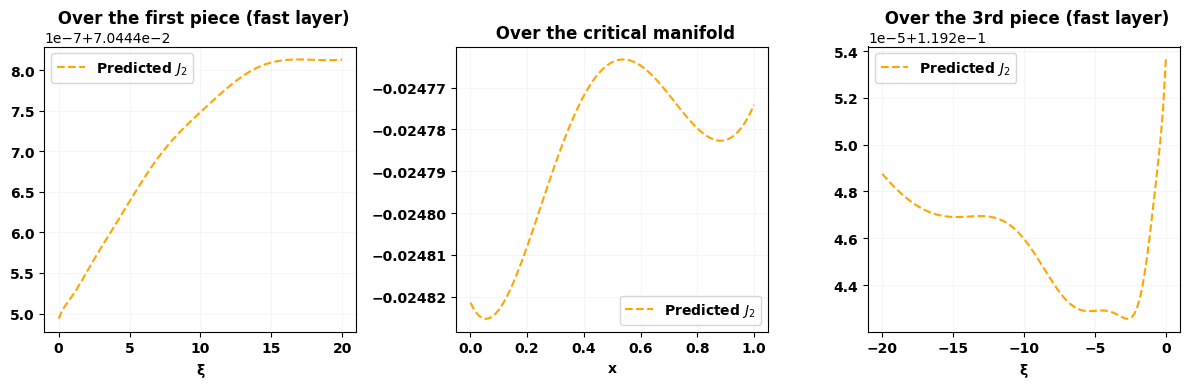

array([0.11925364, 0.11925146, 0.11925004, 0.11924889, 0.1192478 ])

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j2_pred_fast, '--', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the first piece (fast layer)', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
#plt.ylim(-0.08, -0.06)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 2)
plt.plot(tau, j2_pred_slow, '--', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{x}$', fontweight='bold')
plt.title(' Over the critical manifold', fontweight='bold')
plt.grid(True, alpha=0.1)
plt.legend(prop={'weight': 'bold'})
#plt.ylim(6.13, 6.16)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 3, 3)
plt.plot(t2, j2_pred_fast2, '--', color='orange', label='Predicted $J_2$')
plt.xlabel('$\\mathbf{\\xi}$', fontweight='bold')
plt.title(' Over the 3rd piece (fast layer)', fontweight='bold')
plt.legend(prop={'weight': 'bold'})
#plt.ylim(0.07, 0.08)

# Making tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

j2_pred_fast2[:5]

/tmp/ipykernel_69/4118031428.py:30: RuntimeWarning: invalid value encountered in sqrt
  y[i] = np.sqrt(c1(r[i], tt[i]) + c2(r[i], tt[i]))


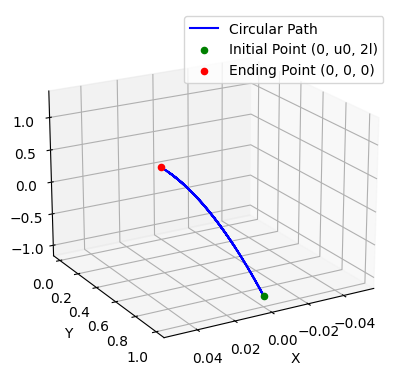

In [23]:
# initial point be (0, u0, 2l) (where u0>0 and l>0 are fixed) and ending point be (0,0,0)

import numpy as np
import matplotlib.pyplot as plt
 
 
r_initial = 1  
r_end = 0 
t_start = 0 
t_end =   6 * np.pi  

# Define the time parameter t and r as a function of t
tt = np.linspace(t_start, t_end, 1000)
r = np.linspace(r_initial, r_end, 1000)

# Define the functions c1(r,t) and c2(r,t)
def c1(r, tt):
    return r * np.cos(tt)

def c2(r, tt):
    return -r * np.sin(tt)

# Calculate the path coordinates
x = np.zeros_like(tt)
y = np.zeros_like(tt)
z = np.zeros_like(tt)

for i in range(len(tt)):
    x[i] = 0  
    y[i] = np.sqrt(c1(r[i], tt[i]) + c2(r[i], tt[i]))
    z[i] = -c1(r[i], tt[i]) - c2(r[i], tt[i])

u0 = y[0]
l = z[0]/2

# Plot the 3D path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, label='Circular Path', color='b')
ax.scatter(0, u0, 2 * l, color='g', label='Initial Point (0, u0, 2l)')
ax.scatter(0, 0, 0, color='r', label='Ending Point (0, 0, 0)')

ax.view_init(elev=20, azim=60)

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()


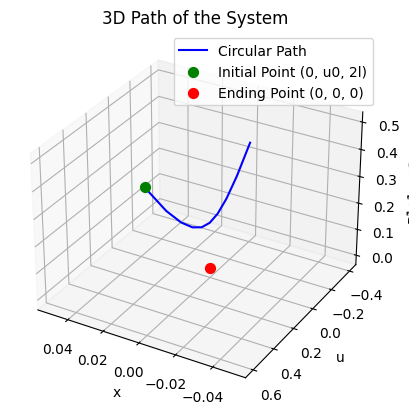

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


eps =0.01
z1 = 1
z2= -1

def fast_system(y, t, eps):
    u, c1, c2, w = y
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u #- eps * j1
    dc2dt  = -z2 * c2 * u #- eps * j2
    dwdt   = 0 #eps
    
    return [dudt, dc1dt, dc2dt, dwdt]

# Initial conditions
z1= 1
z2 = -1
u0 = .6
l1 = 0.6
l2 = 0.1
y0 = [ u0, l1, l2, 0]  # Initial values [u, c1, c2, w]

# Time vector
t_end = 4
tt = np.linspace(0, t_end, 10)

# Solve the system
solution = odeint(fast_system, y0, tt, args=(eps,))

# Extract results
u, c1, c2, w = solution.T

# Plot the 3D path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(w, u, z1 * c1 + z2 * c2, '-', label='Circular Path', color='b')
ax.scatter(0, u0,  z1 * l1 + z2 * l2, color='g', label='Initial Point (0, u0, 2l)', s=50)
ax.scatter(0, 0, 0, color='r', label='Ending Point (0, 0, 0)', s=50)

# Labels and legend
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_zlabel('z1c1 +z2c2')
ax.set_title('3D Path of the System')
ax.view_init(elev=30, azim=120)
ax.legend()

plt.show()
